Plots for the experiments comparing DSCO (Li), C-OCBA (Gao), IKG (ML_IKG), and
GP-C-OCBA (ML_Gao).

Found 300 output files.
Plotting [100, 100, 100] outputs!
average wall times [3084.7571815037727, 266.90234176635744, 3050.4353223466874]
Found 300 output files.
Plotting [100, 100, 100] outputs!
average wall times [1445.6555640387535, 281.82254841327665, 2651.18897649765]
Found 300 output files.
Plotting [100, 100, 100] outputs!
average wall times [6802.576566765309, 618.4262866401673, 11510.186283702851]
Found 300 output files.
Plotting [100, 99, 94] outputs!
average wall times [4259.854824767112, 523.1343190116112, 19300.2811357696]


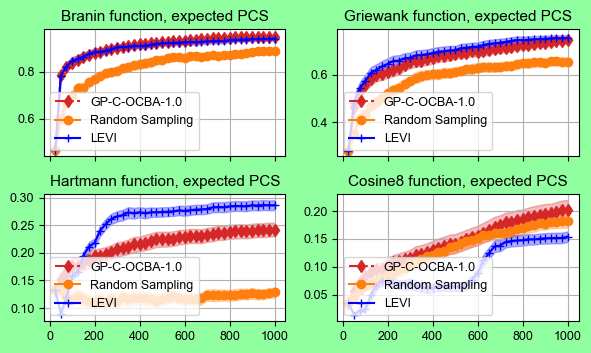

In [33]:
import json
import os

import torch
from torch import Tensor

%matplotlib inline
import matplotlib.pyplot as plt

font_args = {
    "family": "sans-serif",
    "sans-serif": "Arial",
    # "size": 9,
}
# plt.rc("font", **font_args)
# plt.rcParams["font.family"] = "cursive"
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"

SMALL_SIZE = 9
MEDIUM_SIZE = 9
BIGGER_SIZE = 11


plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# current_dir = os.path.dirname(os.path.abspath(__file__))
current_dir = os.getcwd()

plot_kwargs = {
#     "ML_IKG": {"ls": "-.", "marker": "p", "color": u'#e377c2'},
    "GP-C-OCBA-1.0": {"ls": "-.", "marker": "d", "color": u'#d62728'},
    "random": {"marker": "o", "color": u'#ff7f0e'},
#     "GP-C-OCBA-1.0": {"marker": "+", "color": u'#2ca02c'},
#     "GP-C-OCBA-0.5": {"marker": "+", "color": "b"},
    "LEVI": {"marker": "+", "color": "b"},
}
plot_titles = {
    "config_branin": "Branin function, expected PCS",
    "config_greiwank": "Griewank function, expected PCS",
    "config_hartmann": "Hartmann function, expected PCS",
    "config_cosine8": "Cosine8 function, expected PCS",

#     "config_b_3_mean": "Branin function, expected PCS",
    # "config_b_3_worst": "Branin function, worst-case PCS",
    # "config_g_4_worst": "Griewank function, worst-case PCS",
    # "config_h_4_mean": "Hartmann function, expected PCS",
    # "config_c_5_mean": "Cosine8 function, expected PCS",
}
labels = {
#     "ML_IKG": "IKG",
#     "GP-C-OCBA": "GP-C-OCBA",
    "GP-C-OCBA-1.0": "GP-C-OCBA-1.0",
#     "GP-C-OCBA-0.5": "GP-C-OCBA-0.5",
    "random": "Random Sampling",
#     "Li": "DSCO",
#     "Gao": "C-OCBA"
     "LEVI": "LEVI",
}

all_keys = list(plot_kwargs.keys())
plot_idcs = None
moving_average_window = 1
plot_errors = True
figsize = (6, 3.6)
# figsize = (16, 12)

fig, axes = plt.subplots(nrows=2, ncols=2, sharex="all", figsize=figsize, squeeze=False)


def plot_experiment(
    dirname: str, row: int, col: int,
) -> Tensor:
    exp_dir = os.path.join(current_dir, dirname)
    config_path = os.path.join(exp_dir, "config.json")

    with open(config_path, "r") as f:
        config_dict = json.load(f)
        # print(f"Config: \n {json.dumps(config_dict, indent=4)}")
    expected_iterations = config_dict["iterations"]

    # get all the output files
    directory_list = os.listdir(exp_dir)
    output_files = [
        os.path.join(exp_dir, file) for file in directory_list if file[-3:] == ".pt"
    ]
    print(f"Found {len(output_files)} output files.")

    # plot final values, averaged over replications.
    # final values is a list of tensors, one tensor per label
    key = "pcs"

    output_lists = [list() for _ in all_keys]
    wall_times = [0.] * len(all_keys)
    time_counts = [0] * len(all_keys)
    for out_path in output_files:
        try:
            out_dict = torch.load(out_path)
        except Exception:
            continue
        label_idx = all_keys.index(out_dict["label"])
        output = out_dict[key].cpu()

        if output.shape[0] == expected_iterations or \
                (output.shape[0] == 1000 and label_idx == 0 and ("h_4" in dirname or
                                                                 "c_5" in dirname)):
            output_lists[label_idx].append(output)
            wall_times[label_idx] += float(out_dict["wall_time"][999])
            time_counts[label_idx] += 1

    # calculate the mean and std for plotting
    key_counts = list()
    plot_means = list()
    plot_stds = list()
    for out_list in output_lists:
        try:
            out_tensor = torch.stack(out_list)
            key_counts.append(out_tensor.shape[0])
            mean = out_tensor.mean(dim=0)
            std = out_tensor.std(dim=0) / (float(len(out_tensor)) ** 0.5)
            if moving_average_window > 1:
                tmp_mean = torch.zeros_like(mean)
                tmp_std = torch.zeros_like(std)
                for i in range(tmp_mean.shape[0]):
                    l_ind = max(0, i - moving_average_window)
                    tmp_mean[i] = torch.mean(mean[l_ind: i+1])
                    tmp_std[i] = torch.mean(std[l_ind: i+1])
                mean = tmp_mean
                std = tmp_std
            plot_means.append(mean)
            plot_stds.append(std)
        except:
            key_counts.append(0)
            plot_means.append(None)
            plot_stds.append(None)

    print(f"Plotting {key_counts} outputs!")

    for i in range(len(all_keys)):
        if wall_times[i]:
            wall_times[i] /= time_counts[i]

    print(f"average wall times {wall_times}")

    # plot
    ax = axes[row, col]

    plot_idcs = range(len(key_counts))

    for i in plot_idcs:
        if plot_means[i] is None or all_keys[i] not in labels:
            continue
        if plot_errors:
            markers, caps, bars = ax.errorbar(
                x=torch.arange(plot_means[i].shape[0]),
                y=plot_means[i],
                yerr=plot_stds[i],
                errorevery=20,
                label=labels[all_keys[i]],
                markevery=20,
                **plot_kwargs[all_keys[i]]
            )
            # loop through bars and caps and set the alpha value
            [bar.set_alpha(0.5) for bar in bars]
            [cap.set_alpha(0.5) for cap in caps]
        else:
            y = plot_means[i][::25]
            x = torch.arange(1, len(y) + 1) * 25
            ax.plot(
                x, 
                y,
                label=labels[all_keys[i]],
                markevery=1,
                **plot_kwargs[all_keys[i]]
            )
        if plot_shaded:
            yerr=err_coef*plot_stds[i][::25]
            ax.fill_between(
                x,
                y-yerr,
                y+yerr,
                alpha=0.3,
                color=plot_kwargs[all_keys[i]]["color"],
            )
    ax.grid()
    ax.legend(loc=3, prop={'size': MEDIUM_SIZE})
    ax.set_title(plot_titles[dirname], fontdict={"fontsize": BIGGER_SIZE})
    return output_lists

plot_errors = False
plot_shaded = True
err_coef = 1.96

_ = plot_experiment("config_branin", row=0, col=0)
_ = plot_experiment("config_greiwank", row=0, col=1)
_ = plot_experiment("config_hartmann", row=1, col=0)
_ = plot_experiment("config_cosine8", row=1, col=1)
# _ = plot_experiment("config_b_3_mean", row=0, col=0)
# _ = plot_experiment("config_b_3_worst", row=0, col=1)
# _ = plot_experiment("config_g_4_mean", row=1, col=0)
# _ = plot_experiment("config_g_4_worst", row=1, col=1)
# _ = plot_experiment("config_h_4_mean", row=2, col=0)
# _ = plot_experiment("config_c_5_mean", row=2, col=1)

fig.tight_layout()
plt.savefig(os.path.join("plots", "combined_plot.pdf"), dpi=300)
fig.patch.set_facecolor('xkcd:mint green')
plt.show()